In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
parent_dir = os.path.dirname(os.getcwd())
path = parent_dir 
save_path = parent_dir + '/'
from optimization import *
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
color_palette = ['#332288',   '#88CCEE',  '#44AA99', '#AA4499', '#DDCC77', '#CC6677', '#AA4499', '#882255']

## Figure S4: Annual V2G costs with varying forecasts

In [18]:
def load_results(results_path, period_string):
    '''Load the cost results into matrices from the specified path and period string.'''
    vin_length = 749
    cost_mat_uncontrolled = []
    cost_mat_v2g_home = []
    cost_mat_v2g_home_day_ahead_daily = []
    
    for vin in np.arange(1,vin_length):
        #skip the vins that do not have data 
        try:
            cost_day_ahead_tmp = pd.read_csv(results_path + 'cost_v2g_home_' + period_string + '_vin_' +str(vin) + 'day_ahead_Falserandom.csv').iloc[:,1]
        except:
           continue

        if cost_day_ahead_tmp.isna().sum() <= 30:
            try:
                cost_mat_uncontrolled.append( pd.read_csv(results_path + 'cost_uncontrolled_' + period_string + '_vin_' +str(vin) + '.csv').iloc[:,1])
                cost_mat_v2g_home.append( pd.read_csv(results_path + 'cost_v2g_home_' + period_string + '_vin_' +str(vin) + '.csv').iloc[:,1])
                cost_mat_v2g_home_day_ahead_daily.append(cost_day_ahead_tmp)
            except:
                continue

    cost_mat_uncontrolled = np.array(cost_mat_uncontrolled)
    cost_mat_v2g_home = np.array(cost_mat_v2g_home)
    cost_mat_v2g_home_day_ahead_daily = np.array(cost_mat_v2g_home_day_ahead_daily)

    cost_mat_v2g_home_day_ahead = np.zeros((cost_mat_uncontrolled.shape[0], cost_mat_uncontrolled.shape[1]))

    for vin in np.arange(cost_mat_uncontrolled.shape[0]):
        #Replace any nan days with the previous day's value.
        for day in np.arange(cost_mat_v2g_home_day_ahead_daily.shape[1]):
            if np.isnan(cost_mat_v2g_home_day_ahead_daily[vin, day]):
                if day == 0:
                    cost_mat_v2g_home_day_ahead_daily[vin, day] = 0
                else:
                    cost_mat_v2g_home_day_ahead_daily[vin, day] = cost_mat_v2g_home_day_ahead_daily[vin, day-1]

        #Replace any nan weeks with the previous week's value.
        for week in np.arange(cost_mat_uncontrolled.shape[1]):
            if np.isnan(cost_mat_uncontrolled[vin, week]):
                if week == 0:
                    cost_mat_uncontrolled[vin, week] = 0
                else:
                    cost_mat_uncontrolled[vin, week] = cost_mat_uncontrolled[vin, week-1]
            if np.isnan(cost_mat_v2g_home[vin, week]):
                if week == 0:
                    cost_mat_v2g_home[vin, week] = 0
                else:
                    cost_mat_v2g_home[vin, week] = cost_mat_v2g_home[vin, week-1]
            #sum up daily costs to weekly costs
            cost_mat_v2g_home_day_ahead[vin, week] = np.sum(cost_mat_v2g_home_day_ahead_daily[vin, week*7:(week+1)*7])

    return cost_mat_uncontrolled, cost_mat_v2g_home, cost_mat_v2g_home_day_ahead

In [19]:
def plot_costs(ax, cost_mat_uncontrolled, cost_mat_v2g_home, cost_mat_v2g_home_day_ahead, circuit):
    cost_dict = {
        'Baseline': np.mean(np.cumsum(cost_mat_uncontrolled, axis=1), axis=0)[-1],
        'V2G Home': np.mean(np.cumsum(cost_mat_v2g_home, axis=1), axis=0)[-1],
        'V2G Home, Day Ahead': np.mean(np.cumsum(cost_mat_v2g_home_day_ahead, axis=1), axis=0)[-1],
    }
    cost_std_dict = {
        'Baseline': np.std(np.cumsum(cost_mat_uncontrolled, axis=1), axis=0)[-1],
        'V2G Home': np.std(np.cumsum(cost_mat_v2g_home, axis=1), axis=0)[-1],
        'V2G Home, Day Ahead': np.std(np.cumsum(cost_mat_v2g_home_day_ahead, axis=1), axis=0)[-1],
    }

    x = int(circuit[-1]) + int(circuit[-1])*0.45  # the label locations
    width = 0.33  # the width of the bars
    multiplier = 0
    
    for attribute, measurement in cost_dict.items():
        offset = width * multiplier 
        rects = ax.bar(x + offset -.1, measurement, width, label=attribute, color = color_palette[multiplier])
        if measurement <0:
            if circuit == 'cir_1':
                ax.bar_label(rects, labels = ['-$'+str(int(-measurement))], padding=np.abs(measurement)*0.031)
            elif circuit == 'cir_2':
                ax.bar_label(rects, labels = [str(int(measurement))[0] + '$'+str(int(measurement))[1:]], padding=80)
            else:
                ax.bar_label(rects, labels = [str(int(measurement))[0] + '$'+str(int(measurement))[1:]], padding=50)
        else:
            ax.bar_label(rects, labels = ['$'+str(int(measurement))], padding=43)
        multiplier += 1
        if attribute in cost_std_dict:
            ax.errorbar(x + offset -.1, measurement, yerr=cost_std_dict[attribute], fmt='none', color='black', capsize=5)

    min=-3500
    max=3500
    ax.set_ylim(min, max)
    ax.set_yticklabels([str(int(x/1000)) for x in np.arange(min-500, max+1, 1000)], fontsize=15)   
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylabel('Annual Charging Cost [$1000]', fontsize=15)
    if circuit == 'cir_1':
        ax.legend(fontsize=12.5, loc='lower right')

    #remove xticks and xticklabels
    ax.set_xticks([])
    ax.set_xticklabels([])
    
    #add line at y=0
    ax.axhline(0, color='black', linewidth=0.8)
    return

Circuit 1
2011.22 & -2119.53 & -1992.54 & 214.1
Circuit 2
2027.73 & -1709.44 & -1640.13 & 214.1
Circuit 3
2014.05 & -335.12 & -266.84 & 214.1
Circuit 4
2020.05 & 288.51 & 340.94 & 214.1


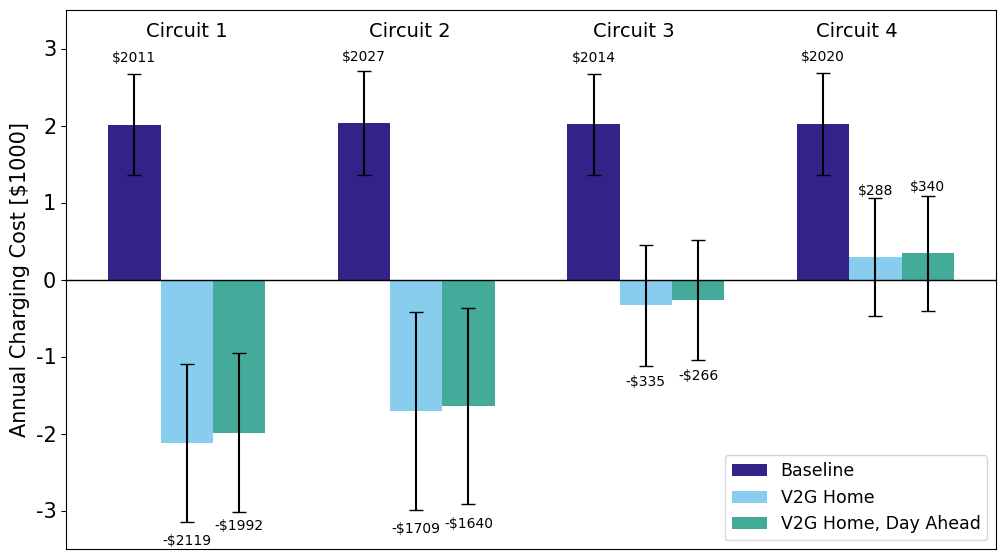

In [20]:
aging = 'batt_aging_0'
period_string = '2024-06-03_to_2025-06-01'

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

for i, circuit in enumerate(['cir_1', 'cir_2', 'cir_3', 'cir_4']):
    print('Circuit ' + str(circuit)[-1])
    circuit_prices = np.array(pd.read_csv(f'Hourly_Prices/circuit_{i+1}_mean_price.csv'))
    #load results
    results_path = 'Results/'+ circuit+ '/' + aging + '/' + 'elrp_1_'
    cost_mat_uncontrolled,cost_mat_v2g_home, cost_mat_v2g_home_day_ahead = load_results(results_path, period_string)

    num_periods = cost_mat_uncontrolled.shape[1]
    plot_costs(ax, cost_mat_uncontrolled, cost_mat_v2g_home, cost_mat_v2g_home_day_ahead,  circuit)
    print(str(np.round(np.mean(np.cumsum( cost_mat_uncontrolled, axis=1), axis=0)[-1],2)) + ' & ' + str(np.round(np.mean(np.cumsum( cost_mat_v2g_home, axis=1), axis=0)[-1], 2)) + ' & ' + str(np.round(np.mean(np.cumsum( cost_mat_v2g_home_day_ahead, axis=1), axis=0)[-1], 2)) + ' & ' + str(np.round(np.mean(np.cumsum( cost_mat_v2g_home_day_ahead_random, axis=1), axis=0)[-1], 2)) )
    ax.annotate('Circuit ' + str(i+1), xy=(i*.24+.13, 0.95), xycoords='axes fraction', ha='center', fontsize=14)

plt.savefig(save_path + 'S4_day_ahead_costs.pdf', bbox_inches='tight')